In [1]:
import torch
from torch import nn
from torchvision import models, transforms

In [2]:
from helper_tools.datasetmaster import make_vision_dataset
from helper_tools.trainer import MyTrainer

In [3]:
# Custom transformation
transform = transforms.Compose([
                transforms.Grayscale(num_output_channels=1),
                transforms.ToTensor(),
            ])

In [4]:
# Path to datasets
train_path = "../Data/Train Dataset/"
test_path = "../Data/Test Dataset/"

In [5]:
# Load Datasets
train_dataset = make_vision_dataset(inputs=train_path, labels=None, transform=transform)
test_dataset = make_vision_dataset(inputs=test_path, labels=None, transform=transform)
# Labels
test_dataset.class_to_idx # type: ignore

{'Dendrites': 0, 'Spheroids': 1}

In [6]:
# Load AlexNet and modify the first layer to accept 1 channel images
alexnet = models.alexnet(weights=None)
alexnet.features[0] = nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2)

# Modify the last fully connected layer for 2 neurons
alexnet.classifier[6] = nn.Linear(in_features=4096, out_features=2, bias=True)

In [7]:
# Use trainer
trainer = MyTrainer(model=alexnet, train_dataset=train_dataset, test_dataset=test_dataset, kind="classification",
                    criterion=nn.CrossEntropyLoss(), batch_size=20, device="cuda", dataloader_workers=4, learn_rate=0.0001)

CUDA not available, switching to CPU.


epoch:    1    training loss: 0.0154    validation loss: 0.0304    accuracy: 83.1%
epoch:    2    training loss: 0.0082    validation loss: 0.0446    accuracy: 89.2%
epoch:    3    training loss: 0.0066    validation loss: 0.0383    accuracy: 90.9%
epoch:    4    training loss: 0.0041    validation loss: 0.0626    accuracy: 93.8%
epoch:    5    training loss: 0.0032    validation loss: 0.0499    accuracy: 93.8%
epoch:    6    training loss: 0.0031    validation loss: 0.0861    accuracy: 93.7%
epoch:    7    training loss: 0.0020    validation loss: 0.0600    accuracy: 93.8%
epoch:    8    training loss: 0.0016    validation loss: 0.0529    accuracy: 93.8%
epoch:    9    training loss: 0.0020    validation loss: 0.0322    accuracy: 93.8%
epoch:   10    training loss: 0.0001    validation loss: 0.0656    accuracy: 93.8%

 epoch:   10    training loss: 0.0001    validation loss: 0.0656    accuracy: 93.8%
Training has been completed without any early-stopping criteria. 

Elapsed time:  34 

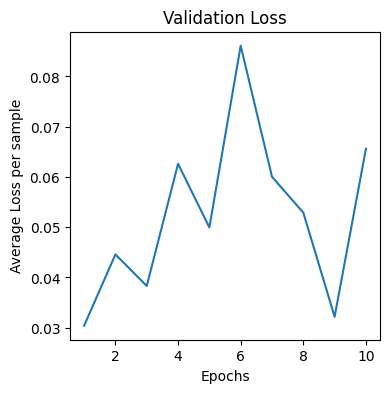

              precision    recall  f1-score   support

           0       0.89      1.00      0.94       800
           1       1.00      0.88      0.93       800

    accuracy                           0.94      1600
   macro avg       0.94      0.94      0.94      1600
weighted avg       0.94      0.94      0.94      1600



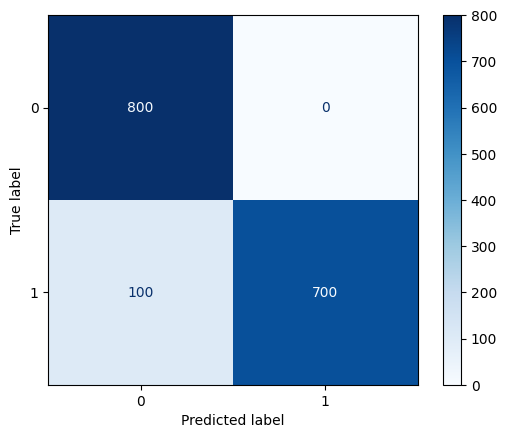

In [8]:
trainer.auto_train(epochs=10, patience=3, cmap='Blues')

In [ ]:
# Save weights
torch.save(alexnet.state_dict(), 'model_weights.pth')